# Scattering for Emission Spectra

Here we describe the self-scattering implementation of pRT. Self-scattering means that photons originating in the planetary atmosphere will be scattered. The details behind this implementation are described in [Mollière et al. (2020)](https://arxiv.org/abs/2006.09394). Self-scattering is the process to consider for (cloudy) brown dwarfs and directly imaged planets. For the optical and near-infrared spectra of close-in planets, also scattering of the stellar light can be important. Thus we are currently porting the stellar scattering implementation of [petitCODE](http://www.mpia.de/homes/molliere/#petitcode) for use in pRT, which will become available soon.

To turn on scattering one must simply pass the keyword ``do_scat_emis = True`` to ``Radtrans()`` when initializing the pRT object. Here we will take the setup identical to the example described in ["Clouds"](clouds.html), considering a Mg$_2$SiO$_4$ cloud.

In [8]:
import numpy as np
from petitRADTRANS import Radtrans

# Load scattering version of pRT
atmosphere = Radtrans(line_species = ['H2O', 'CO_all_iso', 'CH4', 'CO2', 'Na', 'K'], \
      cloud_species = ['Mg2SiO4(c)_cd'], \
      rayleigh_species = ['H2', 'He'], \
      continuum_opacities = ['H2-H2', 'H2-He'], \
      wlen_bords_micron = [0.3, 15], \
      do_scat_emis = True)

pressures = np.logspace(-6, 2, 100)
atmosphere.setup_opa_structure(pressures)


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



Here we define the atmosphere, and some cloud parameters. Again, see the ["Clouds"](clouds.html) page for more information. The parameters are chosen more appropriately for a directly imaged object, specifically by also setting $T_{\rm int}=0$.

In [9]:
from petitRADTRANS import nat_cst as nc
R_pl = 1.2*nc.r_jup_mean
gravity = 1e1**4.0

kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 0.
temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
mass_fractions['He'] = 0.24 * np.ones_like(temperature)
mass_fractions['H2O'] = 0.001 * np.ones_like(temperature)
mass_fractions['CO_all_iso'] = 0.01 * np.ones_like(temperature)
mass_fractions['CO2'] = 0.00001 * np.ones_like(temperature)
mass_fractions['CH4'] = 0.000001 * np.ones_like(temperature)
mass_fractions['Na'] = 0.00001 * np.ones_like(temperature)
mass_fractions['K'] = 0.000001 * np.ones_like(temperature)
mass_fractions['Mg2SiO4(c)'] = 0.0000005 * np.ones_like(temperature)

MMW = 2.33 * np.ones_like(temperature)

Kzz = np.ones_like(temperature)*1e1**7.5
fsed = 2.
sigma_lnorm = 1.05

We will consider clouds that are somewhat thicker than those considered in the ["Clouds"](clouds.html) example. We will also compare to the cloud-free case, and the case neglecting scattering again. For the last case we have to initialize a pRT object with ``do_scat_emis = False``.


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



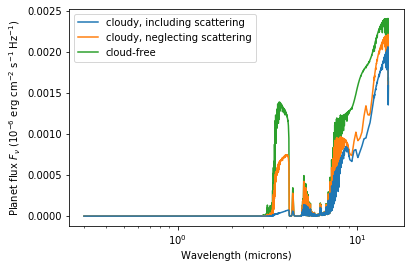

<Figure size 432x288 with 0 Axes>

In [10]:
import pylab as plt
mass_fractions['Mg2SiO4(c)'] = 0.00005 * np.ones_like(temperature)

atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm)
plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, \
         label = 'cloudy, including scattering', zorder = 2)

atmosphere = Radtrans(line_species = ['H2O', 'CO_all_iso', 'CH4', 'CO2', 'Na', 'K'], \
      cloud_species = ['Mg2SiO4(c)_cd'], \
      rayleigh_species = ['H2', 'He'], \
      continuum_opacities = ['H2-H2', 'H2-He'], \
      wlen_bords_micron = [0.3, 15], \
      do_scat_emis = False)
pressures = np.logspace(-6, 2, 100)
atmosphere.setup_opa_structure(pressures)

atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm)
plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, \
         label = 'cloudy, neglecting scattering', zorder = 1)

mass_fractions['Mg2SiO4(c)'] = 0.0 * np.ones_like(temperature)

atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm)
plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, \
         label = 'cloud-free', zorder = 0)

plt.legend(loc='best')
plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()
plt.clf()

# Use better P-T, also talk about parametrized scattering...